<a href="https://colab.research.google.com/github/jamesfloe/cap-comp215/blob/main/lab7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 7: Fractal Dimension of Natural Disturbance
In [1990](https://doi.org/10.1016/0375-9601(90)90451-S) Bak, Chen and Tang proposed a cellular automaton that is an abstract model of a forest fire. Each cell is in one of three states: empty, occupied by forest, or on fire.

3 ecological processes is modelled: forest re-growth, fire ignition, and fire spread

  * empty cells "regenerate" forest at a fixed rate
  * forest fires ignite with a regular but small frequency
  * forested cells catch fire when their neighbours are burning, and burn our in one time step.

In this lab we will write a program that implements this model as a CA and look at the stable landscape patterns that emerge.

In [1]:
!pip install empiricaldist
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.signal import correlate2d
from scipy.stats import linregress



if not os.path.exists('utils.py'):
  !wget  https://raw.githubusercontent.com/pearcej/complex-colab/master/notebooks/utils.py
if not os.path.exists('Cell2D.py'):
  !wget  https://raw.githubusercontent.com/pearcej/complex-colab/master/notebooks/Cell2D.py
from Cell2D import Cell2D, draw_array
from utils import decorate

  Created wheel for empiricaldist: filename=empiricaldist-0.6.3-py3-none-any.whl size=10545 sha256=5f6aef65e106ac39956159795ecc684584eac9e5d2caf456f1fe783a29d3fc6f
  Stored in directory: /root/.cache/pip/wheels/be/4d/30/c131cf1cbb0046f14436cdd7a29f4cc8553d34754e3685d071
Successfully built empiricaldist
--2022-04-17 02:37:42--  https://raw.githubusercontent.com/pearcej/complex-colab/master/notebooks/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2645 (2.6K) [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]   2.58K  --.-KB/s    in 0s      

2022-04-17 02:37:43 (52.9 MB/s) - ‘utils.py’ saved [2645/2645]

--2022-04-17 02:37:43--  https://raw.githubusercontent.com/pearcej/complex-colab/master/notebooks/Cell2D.py
Resolvin

## Data Definitions
let's improve on the textbook's somewhat terse code style and define names for the 3 possible cell states, and a colour map that maps each cell state to an intuitive colour.

In [2]:
EMPTY = 0
OCCUPIED = 1
FIRE = 10

cmap = [(0,0,0) for _ in range(11)]
cmap[EMPTY] = (1, 0.5, 0)    # brown
cmap[OCCUPIED] = (0,  1, 0)  # green
cmap[FIRE] = (1,  0, 0)      # red

forest_colour_map = mpl.colors.ListedColormap(cmap)

## The Cellular Automata
We'll extend the Cell2D CA, and define the step function to implement the 4 rules:
  *  An empty cell becomes occupied with probability p.

  *  A cell with a tree burns if any of its neighbors is on fire.

  *  A cell with a tree spontaneously burns, with probability f, even if none of its neighbors is on fire.

  *  A cell with a burning tree becomes an empty cell in the next time step.

Typical values for the parameters are p=0.01 and f=0.001.

In [3]:
class ForestFire(Cell2D):
  """ 2D Cellular Automaton that simulates a fire-dominated landscape """ 

  def __init__(self, n, p=0.01, f=0.001, q=0.5):
    """Initializes the attributes.

    n: number of rows
    p: probability an empty cells becomes "forested" (occupied)
    f: probability of spontaneous file (e.g., 1/fire ignition interval)
    q: initial forest density (probability cell is "forested" in initial state)
    """
    # TODO: define internal model state variables and initialize landscape with approx. q proportion of cells OCCUPIED
    self.kernel = np.array([[0, 1, 0],
                            [1, 0, 1],
                            [0, 1, 0]]) 
    self.p = p
    self.f = f
    self.array = np.random.choice([OCCUPIED, EMPTY], size=(n,n), p=[q, 1-q])
    self.size = (n*n)
    self.n = n


     
    
    


  def step(self):
    """Executes one time step, applying the CA rules to regnerate empty cells and spread fire to occupied neighbours."""
    # TODO: define the rules for the CA.  This is a significant challenge b/c there are 4 rules and they must act independently!
    a = self.array
    c = correlate2d(a, self.kernel, mode='same')
    #conditions
    neighbors_on_fire = c>= FIRE
    no_nearby_fire = c< FIRE
    is_empty = a==EMPTY
    is_occupied = a==OCCUPIED
    is_onfire = a==FIRE
    #print(np.where(is_empty))
    a[is_empty] = np.random.choice([OCCUPIED, EMPTY], size=a[is_empty].shape, p=[self.p, 1-self.p])
    a[is_onfire] = EMPTY 
    a[is_occupied] = np.random.choice([OCCUPIED, FIRE], size=a[is_occupied].shape, p=[1-self.f, self.f])
    a[neighbors_on_fire & is_occupied] = FIRE
    



  def num_occupied(self):
    """ return the number of cells occupied by forest """
    #return 0  # TODO: count the number of forested cells.
    count = 0
    return len(self.array[self.array == OCCUPIED])
        

  def pct_occupied(self):
    """ return the proportion of cells occupied by forest """
    return self.num_occupied()/self.size

  def draw(self):
    """Draws the CA cells using the forest colour map so values are coloured intuitively."""
    plt.axes().set_title("Occupied: {}%".format(round(self.pct_occupied()*100, 2)))
    draw_array(self.array, cmap=forest_colour_map, vmin=0, vmax=len(forest_colour_map.colors))

  def proportionOccupied(forest,run_length=200):
    """Returns a list of the pct_occupied values"""
    occupied = [forest.pct_occupied()]
    for _ in range(run_length):
      forest.step()
      occupied.append(forest.pct_occupied())
    return occupied

    




    


## Animation
Create a simple animation (using Cell2d.animate method) so we can visualize and verify the system dynamics

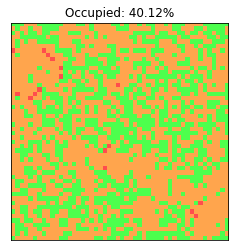

In [4]:
# TODO: your code here.
#  Suggestions: use a small grid (e.g., 20x20)  and
#               a short animation (100 frames) with interval=0.3, to slow it down so you can inspect its behvaviour
fire = ForestFire(50)
fire.animate(frames=100,interval=0.3)


## Steady State
Starting from a random initial condition, run the model until it reaches a "steady state" where the number of trees no longer increases or decreases consistently.
How might we visualize this system or take measurements to determine steady-state?
Start by making a plan for an experiment and visualiztion that will allow you to estimate the steady-state proportion of occuppied cells.

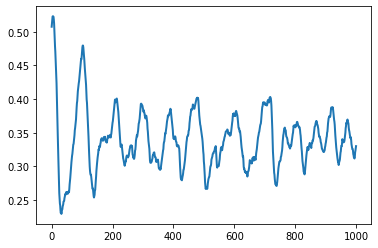

In [5]:
# TODO: compute the long-term average steady-state proportion of occupied cells.
def proportionOccupied(forest,run_length=1000):
  """Returns a list of the pct_occupied values"""
  occupied = [forest.pct_occupied()]
  for _ in range(run_length):
    forest.step()
    occupied.append(forest.pct_occupied())
  return occupied

forest = ForestFire(50)
pctoccupied = proportionOccupied(forest, 1000)
plt.plot(pctoccupied)

## Fractal Dimension
In steady state, is the geometry of the landscape fractal?
What is its fractal dimension?

The code below is re-purpose from the ``plot_perc_scaling`` function presented in Chapter 9.
It splits that function in 2: first to generate the scaling data (occupied cells by grid size), then to plot the results.

In [6]:
def calc_forest_scaling(sizes, p=0.01, f=0.001, q=0.33, run_length=200):
    """ return a vector with one value for number of occupied cells in stable landscape, for each grid size provided """
    occupied = []
    for size in sizes:
        forest = ForestFire(n=size, p=p, f=f, q=q)
        for _ in range(run_length):
            forest.step()
        occupied.append(forest.num_occupied())
    return occupied


def plot_forest_scaling(sizes, occupied):
    """ plot the # of occupied cells by the size of the simulation grid """
    plot_options = dict(xlabel='scale', ylabel='N occupied', xscale='log', yscale='log')
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=plot_options)

    line_options = dict(linestyle='dashed', color='gray', alpha=0.7)
    ax.plot(sizes, sizes**2, label='d=2', **line_options)    # y =  x**2
    ax.plot(sizes, occupied, '.', label='occupied')
    ax.plot(sizes, sizes, label='d=1', **line_options)       # y = x
    ax.legend()

    # linear regression to estimate the slope of 3 lines (square, koch perim, linear) to estimate their dimension
    for label, ys in [('square', sizes**2), ('landscape  ', occupied), ('linear', sizes)]:
        params = linregress(np.log(sizes), np.log(ys))
        print('{label} dimension: {slope}'.format(label=label, slope=params[0]))

If we plot the number of occupied cells versus the size of the box on a log-log scale, the slope estimates the dimension.

But in this model everything scales at the same rate - total area, forested cell sizes, fire sizes, etc., so unsurprisingly, the occupied cells scale proportional to the total grid area, i.e., 2-dimensional.  

What strategy could we employ to estimate the fractal dimension - the relative rate at which the "mass" changes as the length scale changes?

square dimension: 2.0
landscape   dimension: 2.0655790303613886
linear dimension: 1.0


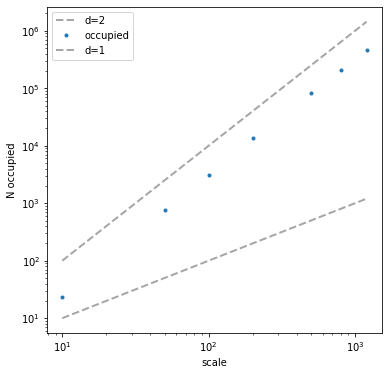

In [7]:
sizes = np.array([10, 50, 100, 200, 500, 800, 1200])
occupied = calc_forest_scaling(sizes)
plot_forest_scaling(sizes, occupied)

**Create Continuous Patches**
This is a surprisingly challenging problem to solve in the general case given how good our visual system is at identifying them! The idea I had here was to start by giving each occupied cell a unique value, then "grow" patches from occupied cells by allowing the smallest of these unique values to propogate to neighbouring cells. Repeat until the propogation is finished.

In [8]:
neighbourhood = np.array([
    [0, 1, 0],
    [1, 1, 1],
    [0, 1, 0],
])

def min_neighbour(a):
    """ Return the smallest non-zero neighbourhood value or 0 if centre cell is a zero """
    p = a*neighbourhood
    centre = tuple(d//2 for d in a.shape)
    return np.min(p[p>0]) if a[centre] else 0

def consolidate(array):
    """ return copy of array with adjacent cells consolidated into a patch with the lowest value among occupied neighbours """
    rows, cols = array.shape
    k = neighbourhood.shape[0]
    array = np.pad(array, 1, 'constant')
    return np.array([
        [min_neighbour(array[row:row+k, col:col+k]) for col in range(cols) ]
            for row in range(rows)
    ])

def patchify(array, category):
    """ Return an array with each contiguous patch identified by a unique integer
    array:  array of int categorical values
    category: the int category value to identify patches

    return: array of same shape with a unique value identifying cells in each patch and zeros elsewhere
    """
    patches = np.zeros(array.shape, dtype=np.uint)
    patches[array==category] = range(1, len(array[array==category])+1)

    patches_growing = np.array([True,])
    while np.any(patches_growing):
        prev_patches = patches
        patches = consolidate(prev_patches)
        patches_growing = patches != prev_patches  # patches are growning until consolidate algorithm stablaizes.
    return patches

def plot_patch_sizes(patch_sizes, min_size=1, scale='linear', plot_type='bar'):
    """ plot the distribution of patch sizes for the array of patch sizes """
    plot_options = dict(xlabel='patch size', ylabel='N patches', xscale=scale, yscale=scale)
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=plot_options)
    ax.set_title("Patch Size Distribution")

    # get unique patch size classes with count of patches in each size class
    size_classes, counts = np.unique(patch_sizes[patch_sizes>=min_size], return_counts=True)
    if plot_type == 'bar' and scale == 'linear':
        ax.bar(size_classes, counts)
    else:
        ax.plot(size_classes, counts)

    n_patches = len(patch_sizes)
    print('Number of patches:', n_patches, 'Unique patch size classes:', len(size_classes))
    single_cell_patches = np.sum(patch_sizes[patch_sizes==1])
    print('Number of single cell patches:', single_cell_patches, '({pct}%)'.format(pct=round(100*single_cell_patches/n_patches)))
    print('Largest patch size:', np.max(patch_sizes))    


Number of patches: 253 Unique patch size classes: 21
Number of single cell patches: 156 (62%)
Largest patch size: 77


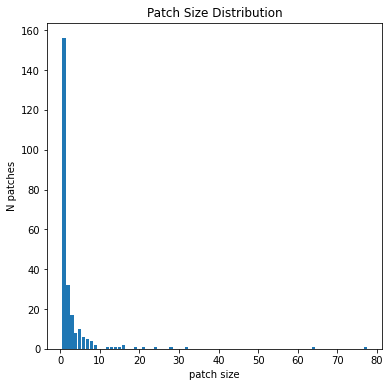

In [9]:
patches = patchify(forest.array, OCCUPIED)
#draw_array(patches, cmap='Greens', vmin=0, vmax=np.max(patches))
patch_ids, patch_sizes = np.unique(patches[patches>0], return_counts=True)
plot_patch_sizes(patch_sizes)

In [10]:
def count_cells(a):
    """Counts the number of cells in boxes with increasing size.
    
    a: NumPy array
    
    returns: list of (i, i**2, cell count) tuples
    """
    n, m = a.shape
    end = min(n, m)
    
    res = []
    for i in range(1, end, 2):
        top = (n-i) // 2
        left = (m-i) // 2
        box = a[top:top+i, left:left+i]
        total = np.sum(box)
        res.append((i, i**2, total))
        
    return np.transpose(res)

In [11]:
from scipy.stats import linregress

def box_count(forest, level=0, plot=False):
    """Estimates the fractal dimension by box counting.
    
    pile: SandPile
    level: which level from the pile to count
    plot: boolean, whether to generate a plot
    
    returns: estimated fractal dimension
    """
    res = count_cells(forest.array==OCCUPIED)
    steps, steps2, cells = res
    
    # select the range where we have a nonzero number of cells
    legit = np.nonzero(cells)
    steps = steps[legit]
    steps2 = steps2[legit]
    cells = cells[legit]

    if plot:
        # only put labels on the left and bottom subplots
        xlabel = 'Box Size' if level in [2, 3] else ''
        ylabel = 'Cell Count' if level in [0, 2] else ''
    
        options = dict(linestyle='dashed', color='gray', alpha=0.7)
        plt.plot(steps, steps2, **options)
        plt.plot(steps, cells, label='Occupied')
        plt.plot(steps, steps, **options)

        decorate(xscale='log', yscale='log',
                         xlim=[1, 200], loc='upper left',
                         xlabel=xlabel, ylabel=ylabel)
        #thinkplot.bigger_text()

    params = linregress(np.log(steps), np.log(cells))
    return params[0]

fractal dimension is: 1.898302348465035


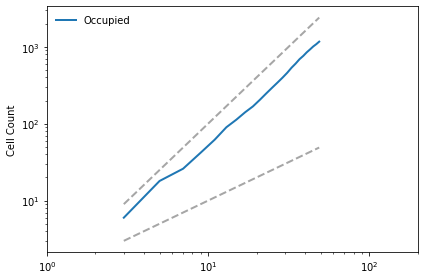

In [12]:
forest = ForestFire(50)
for i in range(100):
  fire.step()


dim = box_count(forest, plot=True)
print("fractal dimension is:", dim)

average dimension: 2.022  minimum dimension: 1.668  max dimension: 2.436


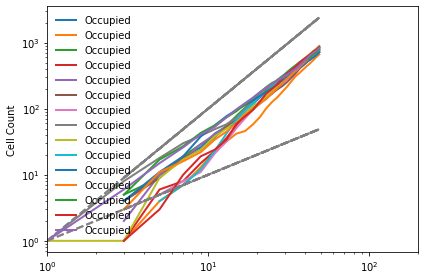

In [13]:
dims = []
for i in range(15):
  forest = ForestFire(50)
  proportionOccupied(forest)
  dims.append(box_count(forest, plot=True))

print("average dimension: %0.3f  minimum dimension: %0.3f  max dimension: %0.3f" % (np.mean(dims), min(dims), max(dims)))

